In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

# renormalize in the 1-excitation subspace; average emitter 2 and 3
raw_data_norm = aqt_results.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0010'] = raw_data_norm[['0100', '0001']].mean(axis=1)

In [3]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 101)

In [4]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

In [8]:
aqt_results.index.get_level_values("Protocol").unique()

Index(['RAW', 'RC', 'NOX'], dtype='object', name='Protocol')

In [17]:
aqt_results.index.names

FrozenList(['Time', 'Protocol', 'Randomizations', 'Identities'])

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_18982/3891616024.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


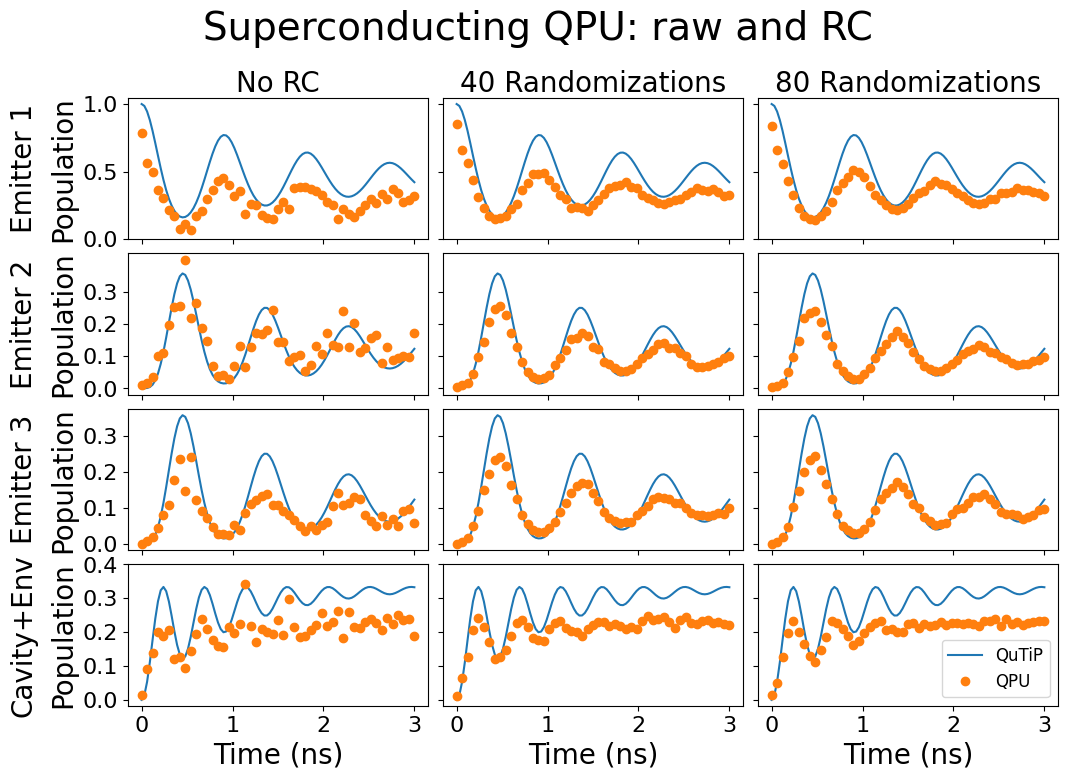

In [68]:
# Plot the raw and RC data in a grid
fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharex=True, sharey="row")

# Removing the individual titles and setting row and column labels
row_labels = ['Emitter 1', 'Emitter 2', 'Emitter 3', 'Cavity+Env']
col_labels = ['No RC', '40 Randomizations', '80 Randomizations']


for ax_row_idx, column in enumerate(qutip_results.columns):
    # Plot the raw results in columns 0
    aqt_raw = aqt_results.xs("RAW", level="Protocol")
    ax = axes[ax_row_idx, 0]

    ax.plot(qutip_results.index, qutip_results[column], label="QuTiP")

    times = aqt_raw.index.get_level_values("Time")
    aqt_column = aqt_bitstrs[column]
    ax.plot(times, aqt_raw[aqt_column], marker='o', linestyle='', label="QPU")

    # Plot the RC results in columns 1 and 2
    for ax_col_idx, num_rc in zip([1, 2], [40, 80]):
        ax = axes[ax_row_idx, ax_col_idx]

        ax.plot(qutip_results.index, qutip_results[column], label="QuTiP")

        aqt_rc = aqt_results.xs("RC", level="Protocol").xs(num_rc, level="Randomizations")
        times = aqt_rc.index.get_level_values("Time")
        aqt_column = aqt_bitstrs[column]
        ax.plot(times, aqt_rc[aqt_column], marker='o', linestyle='', label="QPU")


# Add x-labels on the bottom row
for i, ax in enumerate(axes[-1, :]):
    ax.set_xticks([0, 1, 2, 3])
    ax.tick_params(axis='x', labelsize=16)
    ax.set_xlabel("Time (ns)", fontsize=20)
    ax.text(0.5, 4.5, col_labels[i], transform=ax.transAxes,
            ha='center', va='top', fontsize=20)

# Add row labels with larger font size
for ax, row_label in zip(axes[:, 0], row_labels):
    ax.set_ylabel("Population", fontsize=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.text(-0.3, 0.5, row_label, transform=ax.transAxes,
            ha='right', va='center', fontsize=20, rotation=90)

axes[0][0].set_yticks([0, 0.5, 1])
axes[1][0].set_yticks([0, 0.1, 0.2, 0.3])
axes[2][0].set_yticks([0, 0.1, 0.2, 0.3])
axes[3][0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])

# Set the overall figure title
fig.suptitle("Superconducting QPU: raw and RC", fontsize=28, x=0.467)

# Adjust the main title so it doesn't overlap with the subplots
fig.subplots_adjust(top=0.87, hspace=0.1, wspace=0.05)

plt.legend(fontsize=12)

plt.tight_layout()

In [69]:
fig.savefig("../figures/AQT_raw_and_RC.eps", bbox_inches="tight")